<a href="https://colab.research.google.com/drive/11mGSvbrNkfQl6WNODZ44vU40wEP1XhGX?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Author of this Notebook** : Susnato Dhar (Github : https://github.com/susnato)

<ul>
<li>In this notebook I have implemented Ladder Variational Autoencoders in JAX to generate Mnist Fashion Images from random normal distributions, you can use this notebook to generate more advanced images but for that you might have to modify the final_layer and also fine tune the hyperparameters.</li>

<li>Since Colab does not allow us to train for longer, so I used larger batch_sizes and higher learning_rate, if you want better results then you might have to train for longer with lower batch_sizes and with a learning_rate decay.</li>
</ul>

# Installing Requirements and Imports 

In [2]:
!pip install flax -q

     |████████████████████████████████| 184 kB 5.3 MB/s 
     |████████████████████████████████| 140 kB 45.3 MB/s 
     |████████████████████████████████| 72 kB 447 kB/s 


In [3]:
import jax
import flax
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jrand

key = jrand.PRNGKey(42)

# Load the Data and Make a DataSet

In [4]:
import tensorflow as tf

data = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = data
x_train = x_train/255.0
x_test = x_test/255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

batch_size = 512
ds = tf.data.Dataset.from_tensor_slices((x_train)).batch(batch_size)
ds_len = ds.__len__().numpy()

test_ds = tf.data.Dataset.from_tensor_slices((x_test)).batch(batch_size)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


# Model

In [5]:
class EncoderBlock(nn.Module):
    out_channels : int
    latent_dim : int

    @nn.compact
    def __call__(self, data):
        result = nn.Sequential([nn.Conv(features=self.out_channels, kernel_size=(3, 3), strides=(2, 2), 
                                   padding=((1,1), (1,1))),
                          nn.BatchNorm(use_running_average=True),
                          nn.relu
                         ])(data)
        flatten_result = result.reshape((result.shape[0], -1))
        mu = nn.Dense(self.latent_dim)(flatten_result)
        log_var = nn.Dense(self.latent_dim)(flatten_result)

        return [result, mu, log_var]

class LadderBlock(nn.Module):
    latent_dim : int 

    @nn.compact
    def __call__(self, data):
      x = nn.Sequential([nn.Dense(self.latent_dim),
                        nn.BatchNorm(use_running_average=True)])(data)
      mu = nn.Dense(self.latent_dim)(x)
      log_var = nn.Dense(self.latent_dim)(x)

      return [mu, log_var]
      

In [6]:
from typing import Any

class LVAE(nn.Module):
    latent_dims: Any
    hidden_dims: Any

    def setup(self):
      self.hd_ = self.hidden_dims 

      #encoders=====================================
      modules = []
      for i, h_dim in enumerate(self.hd_):
          modules.append(EncoderBlock(h_dim,
                                      self.latent_dims[i]
                                      ))
      self.encoders = modules
      
      #laders=====================================
      modules = []
      for i in range(len(self.latent_dims) -1, 0, -1):
            modules.append(LadderBlock(self.latent_dims[i-1]))
      self.ladders = modules
      self.decoder_input = nn.Dense(self.hd_[-1] * 4)

      #decoders===================================
      self.hd_ = self.hd_[::-1]
      modules = []
      for i in range(len(self.hd_) - 1):
          modules.append(nn.ConvTranspose(features=self.hd_[i + 1], 
                                          kernel_size=(3, 3), strides=(2, 2), 
                                          padding=((1,2), (1,2)))
                        )
      self.decoder = nn.Sequential(modules)

      #final layer==================================
      self.final_layer = nn.Sequential([nn.ConvTranspose(features=self.hd_[-1], 
                                                         kernel_size=(3, 3),
                                                         strides=(2, 2), 
                                                         padding=((1,2), (1,2))),
                                        nn.BatchNorm(use_running_average=True),
                                        nn.relu,
                                        nn.Conv(features = 3, kernel_size= (3, 3), strides=(2, 2), padding=((1,1),(1,1))),
                                        nn.relu,
                                        nn.Conv(features = 3, kernel_size= (3, 3), strides=(1, 1), padding="VALID"),
                                        nn.relu,
                                        nn.Conv(features = 1, kernel_size= (3, 3),  padding="VALID"),
                                        nn.sigmoid
      ])

      self.hd_ = self.hd_[::-1]


    def encode(self, input):
      """
      Encodes the input by passing through the encoder network
      and returns the latent codes.
      :param input: (Tensor) Input tensor to encoder [N x C x H x W]
      :return: (Tensor) List of latent codes
      """
      h = input
      # Posterior Parameters
      post_params = []

      for encoder_block in self.encoders:
          h, mu, log_var = encoder_block(h)
          #print(mu.shape, log_var.shape)
          post_params.append((mu, log_var))

      return post_params

    def reparameterize(self, mu, logvar):
      """
      Reparameterization trick to sample from N(mu, var) from
      N(0,1).
      :param mu: (Tensor) Mean of the latent Gaussian [B x D]
      :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
      :return: (Tensor) [B x D]
      """
      var = jnp.exp(logvar)
      sigma = jnp.sqrt(var)
      x = mu + sigma * jrand.normal(key, shape=sigma.shape)

      return x

    def decode(self, z, post_params):
      """
      Maps the given latent codes
      onto the image space.
      :param z: (Tensor) [B x D]
      :return: (Tensor) [B x C x H x W]
      """
      kl_div = 0
      post_params.reverse()
      for i, ladder_block in enumerate(self.ladders):
          mu_e, log_var_e = post_params[i]
          mu_t, log_var_t = ladder_block(z)
          mu, log_var = self.merge_gauss(mu_e, mu_t, log_var_e, log_var_t)
          z = self.reparameterize(mu, log_var)
          kl_div += self.compute_kl_divergence(z, (mu, log_var), (mu_e, log_var_e))

      result = self.decoder_input(z)
      result = jnp.reshape(result, (-1, 2, 2, self.hd_[-1]))
      result = self.decoder(result)
      return self.final_layer(result), kl_div

    def merge_gauss(self, mu_1, mu_2, log_var_1, log_var_2):
      p_1 = 1. / (jnp.exp(log_var_1) + 1e-7)
      p_2 = 1. / (jnp.exp(log_var_2) + 1e-7)

      mu = (mu_1 * p_1 + mu_2 * p_2)/(p_1 + p_2)
      log_var = jnp.log(1./(p_1 + p_2))
      return [mu, log_var]

    def compute_kl_divergence(self, z, q_params, p_params):
      mu_q, log_var_q = q_params
      mu_p, log_var_p = p_params
      kl = (log_var_p - log_var_q) + (jnp.exp(log_var_q) + (mu_q - mu_p)**2)/(2 * jnp.log(log_var_p)) - 0.5
      kl = jnp.sum(kl, axis = -1)
      return kl

    @nn.compact
    def __call__(self, data):
      post_params = self.encode(data)
      mu, log_var = post_params.pop()
      z = self.reparameterize(mu, log_var)
      recons, kl_div = self.decode(z, post_params)

      return [recons, data, [mu, log_var]]


# Define TrainState and start Training

In [7]:
import optax
from flax.training import train_state

class TrainState(train_state.TrainState):
    batch_stats : Any


lvae = LVAE(latent_dims=[4,8,16,32,128], hidden_dims=[32, 64,128, 256, 512])
batch = jnp.ones((16, 28, 28, 1))
vars = lvae.init(key, batch)

optimizer = optax.adam(learning_rate=0.0005)
state = TrainState.create(apply_fn=lvae.apply, params=vars['params'], batch_stats=vars['batch_stats'],
                   tx=optimizer)

In [8]:
def compute_metrics(pred, true):
  decoder_pred = jnp.clip(pred[0], 0.001, 0.99)
  true = jnp.clip(true, 0.001, 0.99)
  latent_mu, latent_log_var = pred[2]

  recons_loss = -jnp.mean((true*jnp.log(decoder_pred)+(1-true)*jnp.log(1-decoder_pred)), axis=[1,2,3])
  latent_loss = -0.5*(jnp.sum(1+latent_log_var-jnp.exp(latent_log_var)-jnp.square(latent_mu), axis=-1))
  loss = recons_loss+(latent_loss/784.0)

  return {'Reconstruction Loss' : jax.device_get(jnp.mean(recons_loss)),
          'Latent Loss' : jax.device_get(jnp.mean(latent_loss)),
          'Loss' : jnp.mean(loss)}

In [9]:
def calculate_eval(state):
  recons = []
  true = []
  mu = []
  log_var = []
  for i in test_ds:
    pred = state.apply_fn({'params':state.params, 'batch_stats':state.batch_stats}, 
                    i, mutable=False)
    recons.append(jnp.array(pred[0]))
    true.append(jnp.array(pred[1]))
    mu.append(jnp.array(pred[2][0]))
    log_var.append(jnp.array(pred[2][1]))

  recons = jnp.concatenate(recons)
  true = jnp.concatenate(true)
  mu = jnp.concatenate(mu)
  log_var = jnp.concatenate(log_var)

  return compute_metrics(pred=[recons, true, [mu, log_var]], true=true)

In [10]:
import sys

def train(state, epochs):
  def loss_function(params):
    y_pred, new_model_state = state.apply_fn({'params':params, 'batch_stats':state.batch_stats}, 
                                               batch['x'].numpy(), mutable=['batch_stats'])
    recons = jnp.clip(y_pred[0], 0.001, 0.99)
    input = jnp.clip(y_pred[1], 0.001, 0.99)
    mu, log_var = y_pred[2]

    recons_loss = -jnp.mean((input*jnp.log(recons)+(1-input)*jnp.log(1-recons)), axis=[1,2,3])
    latent_loss = -0.5*(jnp.sum(1+log_var-jnp.exp(log_var)-jnp.square(mu), axis=-1))

    loss = recons_loss+(latent_loss/784.0)
    loss = jnp.mean(loss, axis=0)
    return loss, (new_model_state, y_pred)

  grad_fn = jax.value_and_grad(loss_function, has_aux=True)

  for e in range(epochs):
    for i, ds_x in enumerate(ds):
      batch = {}
      batch['x'] = ds_x
      aux, grad = grad_fn(state.params)
      batch_loss, (new_model_state, batch_pred) = aux

      state = state.apply_gradients(grads=grad, batch_stats=new_model_state['batch_stats'])
      computed_train_metrics = compute_metrics(pred = batch_pred, true = batch['x'].numpy())
      sys.stdout.write("\rEpoch:{}/{}   Iteration:{}/{}   Loss:{:.4f}   Reconstruction_loss:{:.4f}   Latent_loss:{:.4f}".format(e+1, epochs, i+1, ds_len, computed_train_metrics['Loss'], computed_train_metrics['Reconstruction Loss'], computed_train_metrics['Latent Loss']))

    print('\n')
    computed_val_metrics = calculate_eval(state)
    sys.stdout.write("Validation Results:: Epoch:{}  Validation Loss:{:.4f}   Validation Reconstruction_loss:{:.4f}   Validation Latent_loss:{:.4f}".format(e+1, computed_val_metrics['Loss'], computed_val_metrics['Reconstruction Loss'], computed_val_metrics['Latent Loss']))
    print('\n')

  return state

In [16]:
num_epochs = 10
trained_state = train(state, num_epochs)

Epoch:1/10   Iteration:118/118   Loss:0.3631   Reconstruction_loss:0.3631   Latent_loss:0.0003

Validation Results:: Epoch:1  Validation Loss:0.3470   Validation Reconstruction_loss:0.3470   Validation Latent_loss:0.0003

Epoch:2/10   Iteration:118/118   Loss:0.3474   Reconstruction_loss:0.3474   Latent_loss:0.0000

Validation Results:: Epoch:2  Validation Loss:0.3325   Validation Reconstruction_loss:0.3325   Validation Latent_loss:0.0000

Epoch:3/10   Iteration:118/118   Loss:0.3395   Reconstruction_loss:0.3395   Latent_loss:0.0000

Validation Results:: Epoch:3  Validation Loss:0.3239   Validation Reconstruction_loss:0.3239   Validation Latent_loss:0.0000

Epoch:4/10   Iteration:118/118   Loss:0.3353   Reconstruction_loss:0.3353   Latent_loss:0.0000

Validation Results:: Epoch:4  Validation Loss:0.3195   Validation Reconstruction_loss:0.3195   Validation Latent_loss:0.0000

Epoch:5/10   Iteration:118/118   Loss:0.3316   Reconstruction_loss:0.3316   Latent_loss:0.0000

Validation Resul

# Testing

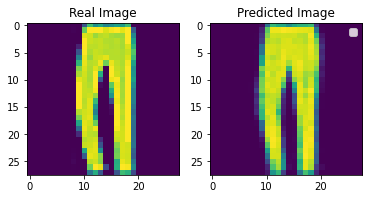

In [17]:
import matplotlib.pyplot as plt

ix = 2 #change the index(0-9999) if you want to try for a different image
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
test_img = x_test[ix].reshape(1, 28, 28, 1)
pred = trained_state.apply_fn({'params':trained_state.params, 'batch_stats':trained_state.batch_stats},
                       jnp.array(test_img), mutable=False)[0]*255.0

pred = pred[0].astype(jnp.uint8).reshape(28, 28)
ax[1].imshow(pred);
ax[1].set_title('Predicted Image');

test_img = test_img*255.0
test_img = test_img.astype(jnp.uint8).reshape(28, 28)

ax[0].imshow(test_img);
ax[0].set_title('Real Image');

plt.legend();

# Generate New Images

In [18]:
#loading the params of the trained_state as vars
vars = {'params':trained_state.params, 'batch_stats':trained_state.batch_stats}

In [19]:
latent_dims=[4,8,16,32,128] 
hidden_dims=[32, 64, 128, 256, 512]

decoder_input = nn.Dense(hidden_dims[-1]*4)
hd = hidden_dims[::-1]

l_vae_ladders = []
for i in range(len(latent_dims)-1, 0, -1):
    lb_ = LadderBlock(latent_dims[i-1])
    l_vae_ladders.append(lb_)

l_vae_decoders = []

for i in range(len(hidden_dims)-1):
    l_vae_decoders.append(nn.ConvTranspose(features=hd[i + 1], 
                                          kernel_size=(3, 3), strides=(2, 2), 
                                          padding=((1,2), (1,2)))
                        )
l_vae_decoder_block = nn.Sequential(l_vae_decoders)

final_layer = nn.Sequential([nn.ConvTranspose(features=hd[-1], 
                                                         kernel_size=(3, 3),
                                                         strides=(2, 2), 
                                                         padding=((1,2), (1,2))),
                                        nn.BatchNorm(use_running_average=True),
                                        nn.relu,
                                        nn.Conv(features = 3, kernel_size= (3, 3), strides=(2, 2), padding=((1,1),(1,1))),
                                        nn.relu,
                                        nn.Conv(features = 3, kernel_size= (3, 3), strides=(1, 1), padding="VALID"),
                                        nn.relu,
                                        nn.Conv(features = 1, kernel_size= (3, 3),  padding="VALID"),
                                        nn.sigmoid
      ])

def decode_fn(z, post_params):
    post_params.reverse()
    for i, ladder_block in enumerate(l_vae_ladders):
          mu_e, log_var_e = post_params[i]
          mu_t, log_var_t = ladder_block.apply({'params':vars['params']['ladders_{}'.format(i)],
                                                'batch_stats':vars['batch_stats']['ladders_{}'.format(i)]}, z)
          mu, log_var = lvae.merge_gauss(mu_e, mu_t, log_var_e, log_var_t)
          z = lvae.reparameterize(mu, log_var)
          
    result = decoder_input.apply({'params':vars['params']['decoder_input']}, z)
    result = jnp.reshape(result, (-1, 2, 2, hidden_dims[-1]))
    result = l_vae_decoder_block.apply({'params':vars['params']['decoder']}, result)
    result = final_layer.apply({'params':vars['params']['final_layer'], 
                   'batch_stats':vars['batch_stats']['final_layer']}, result)
    return result

def generate(post_params):
    mu, log_var = post_params.pop()
    z = lvae.reparameterize(mu, log_var)
    recons = decode_fn(z, post_params)
    recons = recons.reshape(-1, 28, 28)
    return recons


(16, 2048)
(16, 2, 2, 512)


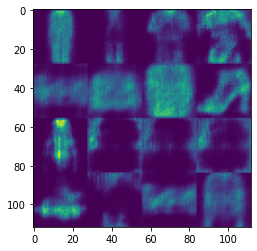

In [20]:
from skimage.util import montage

reconstructions = generate([( jrand.normal(key, (16, 4)),jrand.normal(key, (16, 4)) ), 
                            ( jrand.normal(key, (16, 8)),jrand.normal(key, (16, 8)) ),
                            ( jrand.normal(key, (16, 16)),jrand.normal(key, (16, 16)) ), 
                            ( jrand.normal(key, (16, 32)),jrand.normal(key, (16, 32)) ), 
                            ( jrand.normal(key, (16, 128)),jrand.normal(key, (16, 128)) )])
plt.imshow(montage(reconstructions, grid_shape=(4, 4)))
plt.show()

The generated images are just a shadow of what they could become! But you can still recognize some of them and what the LVAE is trying to generate. For more improvements you can train for longer.